In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.preprocessing

In [28]:
stock_data_bac = pd.read_csv('BAC.csv')

stock_data_bac.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-11,15.32,15.70,15.21,15.63,14.045665,194958400
1,2009-12-14,15.67,15.73,15.43,15.63,14.045665,128586100
2,2009-12-15,15.45,15.51,15.15,15.19,13.650263,190193100
3,2009-12-16,15.33,15.44,15.23,15.28,13.731138,166373000
4,2009-12-17,15.27,15.36,14.83,14.86,13.353713,268907300


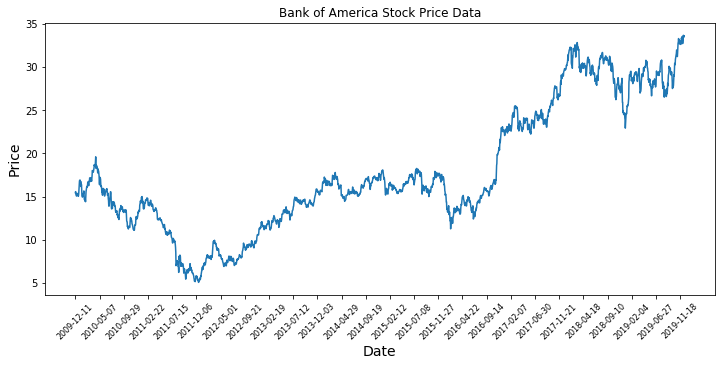

In [85]:
plt.figure(figsize = (12,5))
plt.plot((stock_data_bac['Low'] + stock_data_bac['High']) / 2.0)
plt.xticks(range(0, stock_data_bac.shape[0], 100), stock_data_bac['Date'].loc[::100], rotation = 45, fontsize = 8)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price',fontsize = 14)
plt.title('Bank of America Stock Price Data')
plt.show()

In [30]:
# Index for train, validation and test
train_pct = 0.70
val_pct = 0.20
test_pct = 1 - train_pct - val_pct

print(int(train_pct * stock_data_bac.shape[0]))
print(int(val_pct * stock_data_bac.shape[0]))
print(int(test_pct * stock_data_bac.shape[0]))



min_train_idx, max_train_idx = 0, int(stock_data_bac.shape[0] * train_pct)
min_val_idx, max_val_idx = max_train_idx + 1, max_train_idx + int(stock_data_bac.shape[0] * val_pct)
min_test_idx, max_test_idx = max_val_idx + 1,  stock_data_bac.shape[0]

1761
503
251


In [31]:
def normalize_data(df, input_list, target):
    '''Min-Max Scaler normalization function'''
    temp = df.copy()
    for feat in input_list:
        min_max_scaler = sklearn.preprocessing.MinMaxScaler()
        temp[feat] = min_max_scaler.fit_transform(temp[feat].values.reshape(-1,1))
        if feat == target:
            print('Saving Scaler Parameters...')
            scaler = min_max_scaler
    return temp, scaler

In [32]:
stock_data_normalized, scaler = normalize_data(stock_data_bac, input_list = ['Open','High','Low','Close', 'Adj Close'], target = 'Close')

Saving Scaler Parameters...


In [33]:
input_features = ['Open','High','Low','Close', 'Adj Close']
'''Min-Max Scaler normalization'''
stock_data_bac_norm = stock_data_bac.copy()
for inp_fea in input_features:
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    stock_data_bac_norm[inp_fea] = min_max_scaler.fit_transform(stock_data_bac_norm[inp_fea].values.reshape(-1,1))

In [34]:
stock_data_bac_norm.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-11,0.357368,0.366690,0.359162,0.370990,0.326803,194958400
1,2009-12-14,0.369618,0.367740,0.366841,0.370990,0.326803,128586100
2,2009-12-15,0.361918,0.360042,0.357068,0.355649,0.313239,190193100
3,2009-12-16,0.357718,0.357593,0.359860,0.358787,0.316013,166373000
4,2009-12-17,0.355618,0.354794,0.345899,0.344142,0.303066,268907300


In [35]:
def create_sequences(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    '''Create sequence based on a specified len'''
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets



In [36]:
def conver_to_array(df, list_features, target):
    '''Convert a dataframe into a numpy array to train the model'''
    temp = df[target + list_features]
    float_data = temp.as_matrix()
    return float_data


In [37]:
float_data = conver_to_array(stock_data_bac_norm, list_features = ['Open'], target = ['Close'])
print(float_data)



[[0.37099026 0.35736787]
 [0.37099026 0.36961848]
 [0.35564856 0.3619181 ]
 ...
 [0.9944212  0.99369968]
 [0.99511858 0.99019958]
 [0.99895401 0.99299965]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [38]:
lookback = 15
step = 1
delay = 2
batch_size = 16
train_gen = create_sequences(float_data, lookback = lookback, delay = delay, min_index = 0, max_index = 2000, shuffle = False, step = step, batch_size = batch_size)
val_gen = create_sequences(float_data, lookback = lookback, delay = delay, min_index = 2001, max_index = 2300, shuffle = False, step = step, batch_size = 1)

val_steps = stock_data_bac_norm.shape[0] - 2000 - lookback
print(val_steps)

502


In [39]:
samples, targets = next(train_gen)
print(samples.shape)
print(samples[:3])

(16, 15, 2)
[[[0.37099026 0.35736787]
  [0.37099026 0.36961848]
  [0.35564856 0.3619181 ]
  [0.35878664 0.35771789]
  [0.34414228 0.35561778]
  [0.35006976 0.34651733]
  [0.35878664 0.35351768]
  [0.36053001 0.35876794]
  [0.35564856 0.36226811]
  [0.35774061 0.35421771]
  [0.35913531 0.35701785]
  [0.35320783 0.35666783]
  [0.35146446 0.34756738]
  [0.35111578 0.34931747]
  [0.37308231 0.35456773]]

 [[0.37099026 0.36961848]
  [0.35564856 0.3619181 ]
  [0.35878664 0.35771789]
  [0.34414228 0.35561778]
  [0.35006976 0.34651733]
  [0.35878664 0.35351768]
  [0.36053001 0.35876794]
  [0.35564856 0.36226811]
  [0.35774061 0.35421771]
  [0.35913531 0.35701785]
  [0.35320783 0.35666783]
  [0.35146446 0.34756738]
  [0.35111578 0.34931747]
  [0.37308231 0.35456773]
  [0.39086478 0.3720686 ]]

 [[0.35564856 0.3619181 ]
  [0.35878664 0.35771789]
  [0.34414228 0.35561778]
  [0.35006976 0.34651733]
  [0.35878664 0.35351768]
  [0.36053001 0.35876794]
  [0.35564856 0.36226811]
  [0.35774061 0.354217

In [40]:
print(targets[:2])

[0.40497025 0.41547077]


In [41]:

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.2,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(8, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.2))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
500/500 [==============================] - 13s 25ms/step - loss: 0.0576 - val_loss: 0.2260

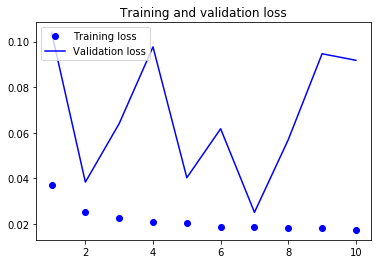

In [49]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [50]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [51]:
series = np.array([1,2,3,4,5,6,7,8,9,10])

In [52]:
n_inputs = 2
generator = TimeseriesGenerator(series, series, length = n_inputs, batch_size = 1)

In [53]:
n_inputs = 15
train_generator = TimeseriesGenerator(float_data, float_data[:,0], start_index = 0, end_index = max_train_idx, length = n_inputs, batch_size = 32, )
val_generator = TimeseriesGenerator(float_data, float_data[:,0], start_index = min_val_idx - n_inputs , end_index = max_val_idx, length = n_inputs, batch_size = 1)
test_generator = TimeseriesGenerator(float_data, float_data[:,0], start_index = min_test_idx - n_inputs , end_index = max_test_idx - 1, length = n_inputs, batch_size = 1)

In [54]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(128,
                     dropout=0.1,
                     recurrent_dropout=0.1,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))

model.add(layers.LSTM(32, activation='relu',
                     dropout=0.2,
                     recurrent_dropout=0.1))


model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_generator,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_generator,
                              validation_steps=len(val_generator))

Epoch 1/10
500/500 [==============================] - 13s 26ms/step - loss: 0.0372 - val_loss: 0.0391

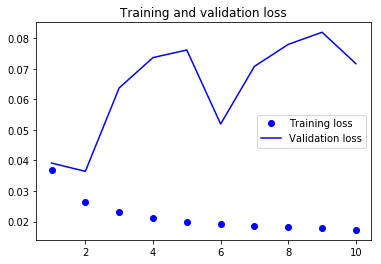

In [55]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [56]:
predictions = model.predict_generator(val_generator)

In [57]:

len(predictions)

503

In [58]:
closing_price = scaler.inverse_transform(predictions)

In [59]:
closing_price_squeeze = closing_price.squeeze()

In [60]:
results = np.concatenate((stock_data_bac['Close'][:max_train_idx], closing_price_squeeze, stock_data_bac['Close'][max_val_idx:max_test_idx]))

In [61]:
len(results)

2517

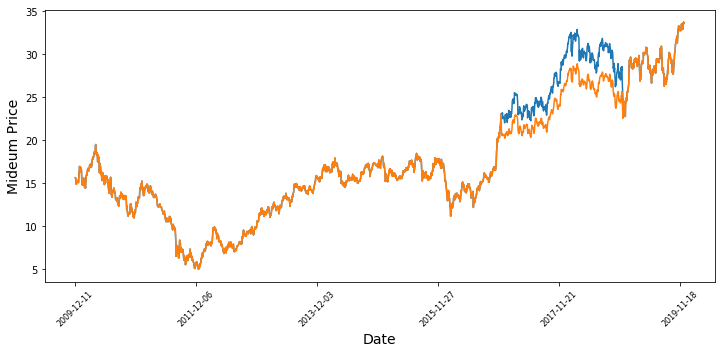

In [62]:
plt.figure(figsize = (12,5))
plt.plot(range(stock_data_bac.shape[0]), (stock_data_bac['Close']))
plt.plot(range(stock_data_bac.shape[0]), (results))
plt.xticks(range(0, stock_data_bac.shape[0], 500), stock_data_bac['Date'].loc[::500], rotation = 45, fontsize = 8)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Mideum Price',fontsize = 14)
plt.show()

In [63]:
predictions_test = model.predict_generator(test_generator)

In [64]:
len(predictions_test)

252

In [65]:
closing_price_test = scaler.inverse_transform(predictions_test)

In [66]:
closing_price_test_squeeze = closing_price_test.squeeze()

In [67]:
results = np.concatenate((stock_data_bac['Close'][:max_val_idx+1], closing_price_test_squeeze))

In [68]:
len(results)

2517

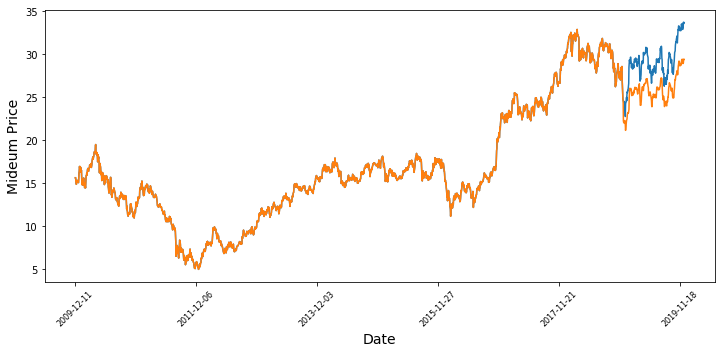

In [69]:
plt.figure(figsize = (12,5))
plt.plot(range(stock_data_bac.shape[0]), (stock_data_bac['Close']))
plt.plot(range(stock_data_bac.shape[0]), (results))
plt.xticks(range(0, stock_data_bac.shape[0], 500), stock_data_bac['Date'].loc[::500], rotation = 45, fontsize = 8)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Mideum Price',fontsize = 14)
plt.show()

In [75]:
############# Another model #####################
import keras
model = Sequential()
model.add(layers.LSTM(256,
                     dropout=0.1,
                     recurrent_dropout=0.2,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))

model.add(layers.LSTM(128, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.2,
                     return_sequences= True))

model.add(layers.LSTM(64, activation='relu',
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     return_sequences= True))

model.add(layers.LSTM(32, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.1,
                      return_sequences= True))

model.add(layers.LSTM(16, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.1))

model.add(layers.Dense(1))

model.compile(optimizer=keras.optimizers.Adam(), loss='mae')
history = model.fit_generator(train_generator,
                              steps_per_epoch=400,
                              epochs=30,
                              validation_data=val_generator,
                              validation_steps=len(val_generator))

Epoch 1/30
400/400 [==============================] - 30s 76ms/step - loss: 0.0548 - val_loss: 0.1953

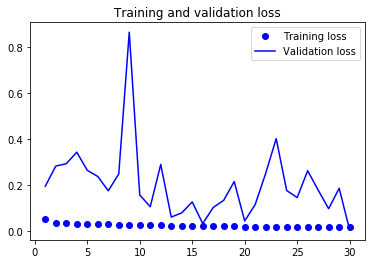

In [76]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

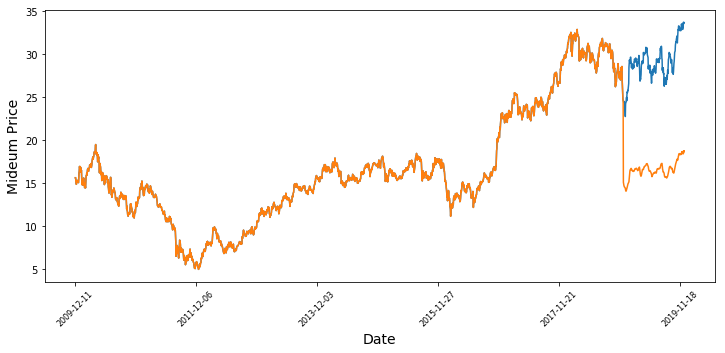

In [72]:
predictions_test = model.predict_generator(test_generator)
closing_price_test = scaler.inverse_transform(predictions_test)
closing_price_test_squeeze = closing_price_test.squeeze()
results = np.concatenate((stock_data_bac['Close'][:max_val_idx+1], closing_price_test_squeeze))

plt.figure(figsize = (12,5))
plt.plot(range(stock_data_bac.shape[0]), (stock_data_bac['Close']))
plt.plot(range(stock_data_bac.shape[0]), (results))
plt.xticks(range(0, stock_data_bac.shape[0], 500), stock_data_bac['Date'].loc[::500], rotation = 45, fontsize = 8)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Mideum Price',fontsize = 14)
plt.show()

In [77]:
import math
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import sklearn

In [78]:
# Linear regression
clfreg = LinearRegression()
X_train = pd.DataFrame(stock_data_bac_norm['Open'][:2264])
y_train = stock_data_bac_norm['Close'][:2264]

X_test = pd.DataFrame(stock_data_bac_norm['Open'][2265:2517])
y_test = stock_data_bac_norm['Close'][2265:2517]

clfreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [79]:
abc = clfreg.predict(X_test)



In [80]:
(abc-y_test)

2265    0.011484
2266    0.008352
2267   -0.011160
2268   -0.008024
2269    0.006260
2270    0.008707
2271   -0.009756
2272    0.018136
2273    0.000387
2274   -0.042504
2275   -0.021260
2276    0.006262
2277   -0.003152
2278   -0.031380
2279    0.012528
2280   -0.017463
2281   -0.000740
2282    0.006578
2283   -0.003881
2284   -0.006667
2285   -0.018172
2286   -0.021666
2287   -0.012613
2288   -0.011971
2289   -0.023483
2290   -0.010602
2291   -0.004673
2292    0.009615
2293   -0.012338
2294   -0.011307
          ...   
2487    0.012673
2488    0.003973
2489   -0.004403
2490   -0.006511
2491   -0.011749
2492   -0.001993
2493   -0.005141
2494   -0.007581
2495   -0.006185
2496    0.000437
2497   -0.003386
2498   -0.001294
2499   -0.001300
2500   -0.004436
2501    0.005319
2502    0.002539
2503   -0.003040
2504   -0.008623
2505   -0.005845
2506    0.000081
2507    0.001473
2508    0.000779
2509   -0.000269
2510    0.000096
2511   -0.003397
2512    0.001482
2513   -0.000625
2514   -0.0013

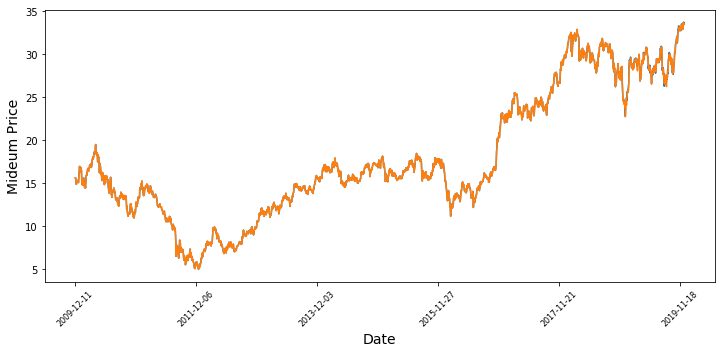

In [81]:
abc = clfreg.predict(X_test)
abc = pd.DataFrame(abc)

closing_price_test = scaler.inverse_transform(abc)
closing_price_test_squeeze = closing_price_test.squeeze()
results = np.concatenate((stock_data_bac['Close'][:max_val_idx+1], closing_price_test_squeeze))

plt.figure(figsize = (12,5))
plt.plot(range(stock_data_bac.shape[0]), (stock_data_bac['Close']))
plt.plot(range(stock_data_bac.shape[0]), (results))
plt.xticks(range(0, stock_data_bac.shape[0], 500), stock_data_bac['Date'].loc[::500], rotation = 45, fontsize = 8)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Mideum Price',fontsize = 14)
plt.show()

In [82]:
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [83]:
stock_data_bac_norm['Open'][:2264]

0       0.357368
1       0.369618
2       0.361918
3       0.357718
4       0.355618
5       0.346517
6       0.353518
7       0.358768
8       0.362268
9       0.354218
10      0.357018
11      0.356668
12      0.347567
13      0.349317
14      0.354568
15      0.372069
16      0.388519
17      0.404970
18      0.415471
19      0.415821
20      0.406370
21      0.396220
22      0.403220
23      0.403570
24      0.383269
25      0.388869
26      0.397270
27      0.355268
28      0.351768
29      0.344067
          ...   
2234    0.742737
2235    0.755338
2236    0.757788
2237    0.769688
2238    0.793140
2239    0.801540
2240    0.799440
2241    0.801890
2242    0.815891
2243    0.818691
2244    0.827441
2245    0.814491
2246    0.792440
2247    0.799440
2248    0.771089
2249    0.790340
2250    0.793490
2251    0.780889
2252    0.786839
2253    0.768988
2254    0.772489
2255    0.781239
2256    0.796990
2257    0.807490
2258    0.799090
2259    0.835842
2260    0.812391
2261    0.7392

In [84]:
pd.DataFrame(stock_data_bac_norm['Open'][2265:2517])

,Open
2265,0.691635
2266,0.684284
2267,0.667483
2268,0.670284
2269,0.684634
2270,0.676934
2271,0.655933
2272,0.658033
2273,0.617781
2274,0.623031
